In [1]:
from numpy import *
import numpy as np
from random import random as rand
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from simfuncs import sample_dist

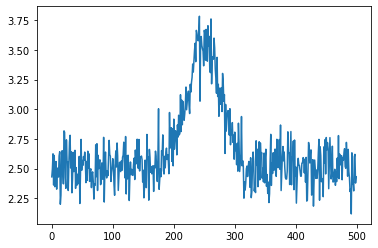

In [5]:
## continuous or static signal, in that the same signal appears in every "shot" or measurement, 
## but is buried in the noise. clearly, we can average to get rid of the noise and converge to
## the signal. this has to do with the randomness of the noise, or rather that the signal is the
## only thing that correlates frame to frame. 

noise = lambda x: alpha*(0.5*rand()) # white noise
alpha = 10
sig = lambda x: (cos(x)*sin(x)/x)**2

pts = 500

avgs = 100
avg = empty(pts)
avg_register = zeros((avgs,pts))

xpts = linspace(-5,5,pts)

for i in range(avgs):
    data = array([sig(x) + noise(alpha) for x in xpts])
    avg_register[0,:] = data
    avg = mean(avg_register,axis=0)
    avg_register = roll(avg_register,pts)

plt.plot(avg)

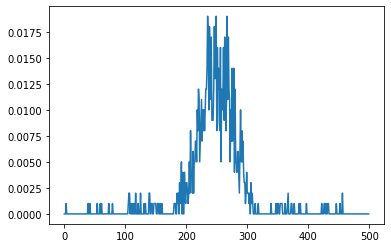

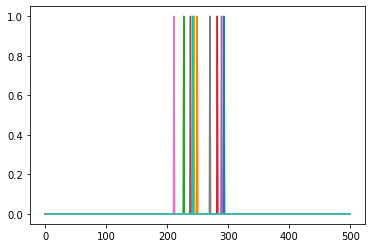

In [6]:
## discrete or dynamic signal, in that the signal fluctuates shot to shot, according to some 
## distribution function, or the signal comes in bursts that show up in a different place each
## time but when added all together reveal the signal. now the correlation between frames
## can not be revealed simply by averaging, as adjacent frames are no longer guaranteed to correlate.

def binary_sample(xpts,fx,fmax,npersamp=1):
    """
    Get 0 or 1s from a probability distribution function (PDF)
    1s are interpreted as signal; i.e. the default return is all 0s.
    
    Args:
        xpts: the values of x to pass to fx.
        fx: callable, the 1D continuous PDF to be sampled, i.e. f(x)
        fmax: the maximum of f(x) on the domain of xpts.
        npersamp: the number of 1s per sample.
    Return:
        sample: np array (float) containing a zero or a one for each x value.
    """
    n = len(xpts)
    y_dist = np.empty(n) 
    f_dist = np.empty(n) 
    sample = np.zeros(n) # this is the distribution we want
    j = 0 # dist index
    
    if npersamp == 0:
        for j,x in enumerate(xpts):
            f = fx(x)
            y = rand()*fmax # rand val on range of f(x)
            if y <= f:
                y_dist[j]=y
                f_dist[j]=f
                sample[j]=1
    else:
        # scramble the indices
        jxvals = array(list(zip(range(n),xpts))) 
        random.shuffle(jxvals) # in-place shuffle
                
        for j,x in jxvals:
            f = fx(x)
            y = rand()*fmax # rand val on range of f(x)
            if y <= f:
                j = int(j)
                y_dist[j]=y
                f_dist[j]=f
                sample[j]=1
            if sum(sample) == npersamp:
                break

    return sample

sig = lambda x: (cos(x)*sin(x)/x)**2

pts = 500

avgs = 1000

shots = empty((avgs,pts))

avg = zeros(pts)
for i in range(avgs):
    shots[i,:] = binary_sample(xpts=xpts,fx=sig,fmax=1)
    avg += shots[i,:]
avg /= avgs
plt.plot(avg)
plt.show()

# sample of individual shots
for i in range(10):
    plt.plot(shots[i,:])
plt.show()

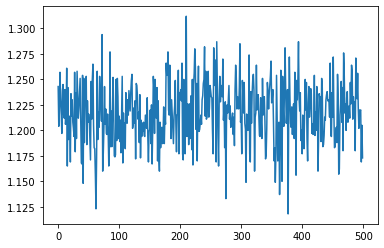

In [10]:
avg = empty(pts)
avg_register = zeros((avgs,pts))

xpts = linspace(-5,5,pts)

v = 1
noise = lambda x: v**x*exp(-v)/np.math.factorial(x) # poissonian noise

for i in range(avgs):
    data = sample_dist(fx=noise,fmax=1,domain=[0,5*sqrt(v)],n=pts,integral=True) + \
        binary_sample(xpts,sig,1) # the higher the last number the more unlikely it is to get a click
    avg_register[0,:] = data
    avg = mean(avg_register,axis=0)
    avg_register = roll(avg_register,pts)

plt.plot(avg)

In [38]:
## use independent component analysis to try to find the signal

def ica_project(slices, kwargs):
    """
    Independent component analysis. returns the data projected on the ICA
    
    'slices': a 2D np.array whose ith row is the data from measurement i
    'kwargs': keyword args for FastICA
    
    returns:
    'ica_mean': the mean of the data rows projected with the mixing matrix.
    'A_ica': the mixing matrix
    """
    
    ica = FastICA(**kwargs)
    ica.fit(slices)
    A_ica = ica.components_  # Get estimated mixing matrix
    ica_mean = np.mean(np.abs(A_ica),axis=0)
    return ica_mean, A_ica

binning = 4
pts = 512//binning
perframe = 100 # the maximum number of clicks we could expect in each frame. 

shots = 512 # number of measurements
xpts = linspace(-5,5,pts)

data = empty((shots,pts))
signal = zeros((shots,pts))

v = 1
noise = lambda x: v**x*exp(-v)/np.math.factorial(x) # poissonian noise

for i in range(shots):
    
    # simulates, e.g., a single photon source where we wait long enough to get several photons per shot
    for event in range(perframe):
        signal[i,:] += binary_sample(xpts,sig,1,npersamp=1) # the 0.01 makes it very likely to get a click
#     signal[i,:] = binary_sample(xpts=xpts,fx=sig,fmax=1,npersamp=10)
    data[i,:] = sample_dist(fx=noise,fmax=noise(v),domain=[0,5*sqrt(v)],n=pts,integral=True) + signal[i,:]
        
# kwargs = {'n_components':pts, 'whiten':'arbitrary-variance', 'max_iter':200}
kwargs = {'n_components':pts, 'whiten':False, 'max_iter':200}

ica_data, A_mix = ica_project(data,kwargs)
print("done")

C:\Users\prest\.virtualenvs\rubidium-6bgZCrz4\lib\site-packages\sklearn\decomposition\_fastica.py:538: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")


done


C:\Users\prest\.virtualenvs\rubidium-6bgZCrz4\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


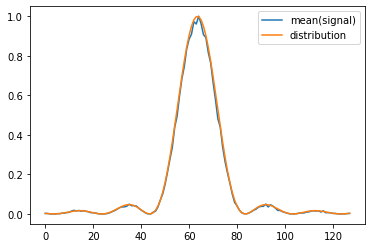

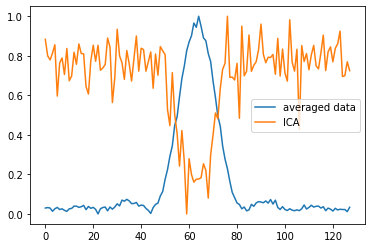

In [43]:
# mean signal with no noise
avgsig = mean(signal,axis=0)
plt.plot(avgsig/max(avgsig),label='mean(signal)')
plt.plot(sig(xpts),label='distribution')
plt.legend()
plt.show()

# signal buried in noise
avg = mean(data,axis=0)
avg -= min(avg)
plt.plot(avg/max(avg),label='averaged data')
# plt.plot(mean(data,axis=0))

# signal extracted with ICA

plt.plot((ica_data-min(ica_data))/(max(ica_data)-min(ica_data)),label='ICA')
plt.legend()
plt.show()

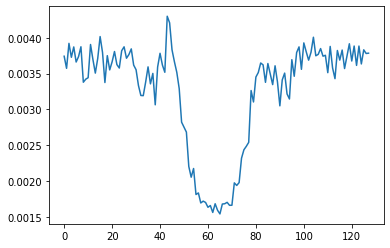

In [35]:
plt.plot(ica_data)